In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import torch 
import torch.nn as nn
import numpy as np 
import matplotlib.pyplot as plt 
from torchvision.datasets import VOCDetection
import torchvision.transforms as transforms 
import matplotlib.patches as patches
from configs import tiny_detection as config
from torchsummary import summary
import cv2

In [2]:
CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
]

In [3]:
image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [155]:
class CelebACustom(VOCDetection):

    def __init__(self, root, image_set, transform, download): 
        super(CelebACustom, self).__init__(root=root, image_set=image_set, download=download)
        self.transform = transform
        self.num_boxes = config.num_boxes
        self.grid_size = config.grid_size
        self.num_classes = len(CLASSES)
        self.cell_size = config.image_height / config.grid_size
        

    def __getitem__(self, index):
        """
        output bbox of shape xmin, ymin, xmax, ymax
        """
        img, annotation = super().__getitem__(index)
        bboxes = []

        objs = annotation["annotation"]["object"]

        target = torch.zeros((self.num_boxes * 5 + self.num_classes, self.grid_size, self.grid_size))

        if self.transform is not None: 
            img = self.transform(img)
        
        old_image_height = img.shape[1] 
        old_image_width = img.shape[2]

        y_scale, x_scale = config.image_height / old_image_height, config.image_width / old_image_width
        
        for obj in objs: 
            xmin = int(obj["bndbox"]["xmin"]) * x_scale
            xmax = int(obj["bndbox"]["xmax"]) * x_scale
            ymin = int(obj["bndbox"]["ymin"]) * y_scale
            ymax = int(obj["bndbox"]["ymax"]) * y_scale

            cls_id = CLASSES.index(obj["name"])

            center_x = xmin + (xmax - xmin) // 2 
            center_y = ymin + (ymax - ymin) // 2 

            responsible_cell_x = int(center_x / self.cell_size)
            responsible_cell_y = int(center_y / self.cell_size)
            bbox = torch.tensor([xmin, ymin, xmax, ymax, 1.0] * self.num_boxes)
            cls_one_hot = torch.zeros((len(CLASSES),))
            cls_one_hot[cls_id] = 1.0
            output_vector = torch.concat([bbox, cls_one_hot])
            target[:, responsible_cell_x, responsible_cell_y] = output_vector        

        # bboxes to tensor         
        img = np.transpose(img.numpy(), (1, 2, 0))
        img = cv2.resize(img, (config.image_height, config.image_width))
        img = torch.permute(torch.tensor(img), (2, 0, 1))

        return img, target



In [156]:
train_dataset =  CelebACustom(root="../../research/dataset/", download=False, image_set="train", transform=image_transforms)
test_dataset = CelebACustom(root="../../research/dataset/", download=False, image_set="val", transform=image_transforms)


In [157]:
def display_bbox(img, bboxes): 

    print(bboxes)
    nb_objs = bboxes.shape[0]
    fig, ax = plt.subplots()
    ax.imshow(img)
    for bbox in bboxes: 
        rect = patches.Rectangle((bbox[0], bbox[1]), (bbox[2] - bbox[0]),(bbox[3] - bbox[1]), linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
    plt.show()

        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[141.568     44.597286 258.944    169.26697 ]
 [ 47.488     88.18099  422.016    425.70135 ]]


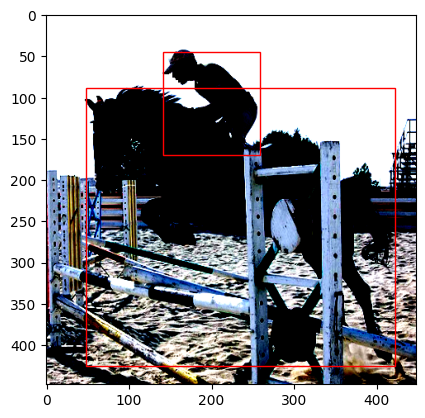

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[ 51.072       1.3700305 146.944     205.5046   ]
 [241.92        1.3700305 338.688     241.12538  ]]


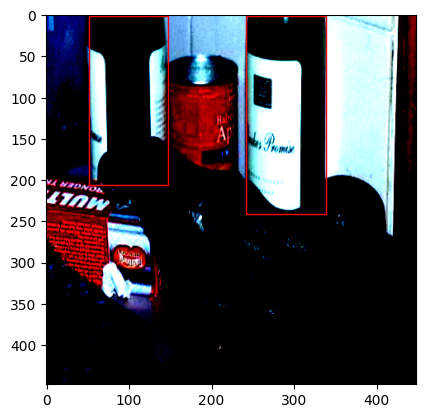

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[129.73334     3.2941177 347.2       324.47058  ]
 [154.        108.70588   296.8       388.70587  ]
 [336.93332     1.6470588 448.        184.47058  ]]


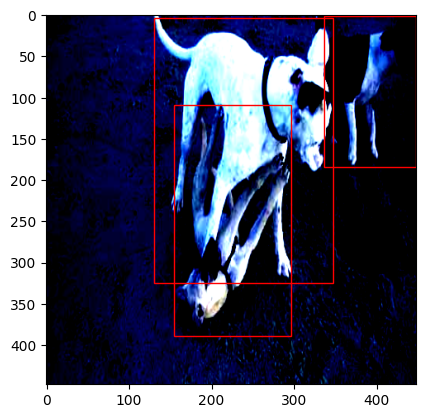

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[ 53.813812  86.912    162.78679  368.256   ]
 [129.15315   34.944    165.47748   92.288   ]
 [184.31232   32.256    227.36336   97.664   ]
 [242.16216   32.256    290.5946    93.184   ]]


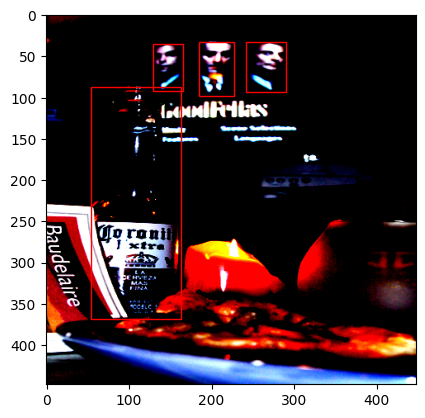

In [158]:
for idx, sample in enumerate(train_dataset): 
    img, target = sample
    # to numpy 
    np_img = torch.permute(img, (1,2,0)).numpy()
    
    boxes = []

    for i in range(target.shape[1]):
        for j in range(target.shape[2]):
            if target[4, i, j] == 1: 
                boxes.append(
                    target[:4, i, j].numpy()
                )

    boxes = np.array(boxes)
    
    display_bbox(np_img, boxes)
    if idx > 2: 
        break 

In [124]:
class YoloV1(nn.Module): 

    def __init__(self, num_classes, num_boxes, grid_size): 
        super().__init__()
        
        self.num_classes = num_classes 
        self.num_boxes = num_boxes 
        self.grid_size = grid_size
        self.output_shape = (grid_size, grid_size, num_boxes * 5 + num_classes)


        self.conv1 = nn.Sequential(            
            nn.Conv2d(3, 64, 7, 2, 3), 
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 192, 3, 1, 1),
            nn.LeakyReLU(), 
            nn.MaxPool2d(2, 2)
        )


        self.conv3 = nn.Sequential(
            nn.Conv2d(192, 192, 1, 1, 0),
            nn.LeakyReLU(), 
            nn.Conv2d(192, 256, 3, 1, 1),
            nn.LeakyReLU(), 
            nn.Conv2d(256, 256, 1, 1, 0),
            nn.LeakyReLU(), 
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.LeakyReLU(), 
            nn.MaxPool2d(2, 2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(512, 256, 1, 1, 0),
            nn.LeakyReLU(), 
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Conv2d(512, 256, 1, 1, 0),
            nn.LeakyReLU(), 
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Conv2d(512, 512, 1, 1, 0),
            nn.LeakyReLU(),
            nn.Conv2d(512, 1024, 3, 1, 1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(1024, 512, 1, 1, 0),
            nn.LeakyReLU(), 
            nn.Conv2d(512, 1024, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Conv2d(1024, 512, 1, 1, 0),
            nn.LeakyReLU(), 
            nn.Conv2d(512, 1024, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Conv2d(1024, 1024, 3, 2, 1),
            nn.LeakyReLU(),        
        )

        self.conv6 = nn.Sequential(
            nn.Conv2d(1024, 1024, 3, 1, 1),
            nn.LeakyReLU(), 
            nn.Conv2d(1024, 1024, 3, 1, 1),
            nn.LeakyReLU()
        )

        self.linear = nn.Linear(1024*7*7, 1470)

    def forward(self, x): 
        bs = x.shape[0]
        out1 = self.conv1(x) 
        out2 = self.conv2(out1) 
        out3 = self.conv3(out2) 
        out4 = self.conv4(out3) 
        out5 = self.conv5(out4) 
        out6 = self.conv6(out5) 
        out6 = out6.view(bs, -1)
        out7 = self.linear(out6)
        out7 = out7.view(bs, *self.output_shape)
        return out7


In [142]:
summary(YoloV1(config.num_classes, config.num_boxes, config.grid_size), (3, 448, 448), device=config.device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 112, 112]        --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        9,472
|    └─LeakyReLU: 2-2                    [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-3                    [-1, 64, 112, 112]        --
├─Sequential: 1-2                        [-1, 192, 56, 56]         --
|    └─Conv2d: 2-4                       [-1, 192, 112, 112]       110,784
|    └─LeakyReLU: 2-5                    [-1, 192, 112, 112]       --
|    └─MaxPool2d: 2-6                    [-1, 192, 56, 56]         --
├─Sequential: 1-3                        [-1, 512, 28, 28]         --
|    └─Conv2d: 2-7                       [-1, 192, 56, 56]         37,056
|    └─LeakyReLU: 2-8                    [-1, 192, 56, 56]         --
|    └─Conv2d: 2-9                       [-1, 256, 56, 56]         442,624
|    └─LeakyReLU: 2-10                   [-1, 256, 56, 56]         -

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 112, 112]        --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        9,472
|    └─LeakyReLU: 2-2                    [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-3                    [-1, 64, 112, 112]        --
├─Sequential: 1-2                        [-1, 192, 56, 56]         --
|    └─Conv2d: 2-4                       [-1, 192, 112, 112]       110,784
|    └─LeakyReLU: 2-5                    [-1, 192, 112, 112]       --
|    └─MaxPool2d: 2-6                    [-1, 192, 56, 56]         --
├─Sequential: 1-3                        [-1, 512, 28, 28]         --
|    └─Conv2d: 2-7                       [-1, 192, 56, 56]         37,056
|    └─LeakyReLU: 2-8                    [-1, 192, 56, 56]         --
|    └─Conv2d: 2-9                       [-1, 256, 56, 56]         442,624
|    └─LeakyReLU: 2-10                   [-1, 256, 56, 56]         -

In [35]:
def compute_iou(pred_boxes, gt_boxes): 
    """
    pred_boxes : (bs, 4)
    gt_boxes : (bs, 4)
    """

    inter_x_min = torch.max(pred_boxes[:, 0], gt_boxes[:, 0])
    inter_y_min = torch.max(pred_boxes[:, 1], gt_boxes[:, 1])
    inter_x_max = torch.min(pred_boxes[:, 2], gt_boxes[:, 2]) 
    inter_y_max = torch.min(pred_boxes[:, 3], gt_boxes[:, 3])

    intersection_w = inter_x_max - inter_x_min 
    intersection_h = inter_y_max - inter_y_min
    intersection_area = intersection_h * intersection_w

    pred_w = pred_boxes[:, 2] - pred_boxes[:,  0]
    pred_h = pred_boxes[:, 3] - pred_boxes[:, 1]

    gt_w = gt_boxes[:, 2] - gt_boxes[:, 0] 
    gt_h = gt_boxes[:, 3] - gt_boxes[:, 1] 

    union_area = (pred_w * pred_h) + (gt_w * gt_h) - intersection_area

    intersection_over_union = torch.clip(intersection_area / union_area, 0, 1)

    return intersection_over_union


# x = torch.tensor([[1202, 123, 1650, 868]]) 
# y = torch.tensor([[1162.0001, 92.0021, 1619.9832, 694.0033]])
# print(x)
# print(y)
# compute_iou(x,y)


In [ ]:
class YoloLoss(nn.Module): 

    def __init__(self, num_boxes, num_classes):
        super().__init__() 
        self.num_boxes = num_boxes 
        self.num_classes = num_classes 

    def forward(self, prediction, target): 
        """
        prediction : (bs, 30, 7, 7)
        target : (bs, 30, 7, 7)
        """
        assert prediction.shape == target.shape 

        # extract boxes 

        pred_boxes = prediction[:, self.num_boxes * 5, : ,: ] # (bs, 5 * n, 7, 7)
        pred_class_probs = prediction[:, self.num_boxes * 5:, :, :] # (bs, num_classes, 7, 7)
